# AI model for predicting the electricity prices

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

## Loading the data

In [2]:
# path to the CSV file
path = '/Users/johan/Downloads/data.csv'

df = pd.read_csv(path)

## Define the model

In [3]:
# Define the Neural Network
class PricePredictionModel(nn.Module):
    def __init__(self, input_size):
        super(PricePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # First hidden layer
        self.fc2 = nn.Linear(64, 32)  # Second hidden layer
        self.fc3 = nn.Linear(32, 1)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer 1
        x = torch.relu(self.fc2(x))  # Activation function for hidden layer 2
        x = self.fc3(x)  # Output layer (no activation for regression)
        return x

## Setup the structure

In [7]:
# Prepare the data
# Assuming 'merged_data' is the dataset we already processed
X = df.drop(columns=['SpotPriceDKK', 'from', 'to'])  # Features (weather data)
y = df['SpotPriceDKK']  # Target (electricity price in DKK)

# Standardize the features for better training performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
model = PricePredictionModel(input_size)

criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Train model

In [13]:
# Train the model
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 10 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 67839.2266
Epoch [200/10000], Loss: 66245.0547
Epoch [300/10000], Loss: 64774.5469
Epoch [400/10000], Loss: 63481.2969
Epoch [500/10000], Loss: 62207.6523
Epoch [600/10000], Loss: 60956.3242
Epoch [700/10000], Loss: 59862.3516
Epoch [800/10000], Loss: 58853.3125
Epoch [900/10000], Loss: 57833.0977
Epoch [1000/10000], Loss: 56959.8125
Epoch [1100/10000], Loss: 55998.0352
Epoch [1200/10000], Loss: 55353.6602
Epoch [1300/10000], Loss: 54397.4336
Epoch [1400/10000], Loss: 53760.8672
Epoch [1500/10000], Loss: 53019.3867
Epoch [1600/10000], Loss: 52348.0703
Epoch [1700/10000], Loss: 51709.7734
Epoch [1800/10000], Loss: 51104.4727
Epoch [1900/10000], Loss: 50442.1562
Epoch [2000/10000], Loss: 49921.4414
Epoch [2100/10000], Loss: 49292.2461
Epoch [2200/10000], Loss: 48775.2734
Epoch [2300/10000], Loss: 48350.0977
Epoch [2400/10000], Loss: 47839.5156
Epoch [2500/10000], Loss: 47370.7461
Epoch [2600/10000], Loss: 46848.8281
Epoch [2700/10000], Loss: 46455.7422
Epoch [280

In [14]:
# Evaluate the model
model.eval()
with torch.no_grad():
    predicted = model(X_test)
    test_loss = criterion(predicted, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 232209.4219


In [3]:
# Step 2: Define the LSTM Model
class LSTMPricePrediction(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMPricePrediction, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer to predict price
        
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_size)  # Initialize hidden state
        c_0 = torch.zeros(1, x.size(0), hidden_size)  # Initialize cell state
        
        # Forward propagate through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # Output is the sequence of hidden states
        
        # Only take the last output for prediction (many-to-one)
        last_output = output[:, -1, :]
        
        # Pass through the fully connected layer
        out = self.fc(last_output)
        return out

In [4]:
# Step 1: Prepare the Data
# Define the input features (weather data + past prices) and the target (price)
features = df.drop(columns=['SpotPriceDKK', 'from', 'to'])  # Features (weather data)
target = df['SpotPriceDKK']  # Target (electricity price in DKK)


# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences of past data to feed into the RNN/LSTM
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

# Define the sequence length (e.g., past 24 hours)
sequence_length = 24

# Create sequences for the LSTM
X, y = create_sequences(features_scaled, target.values, sequence_length)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


# Hyperparameters
input_size = X_train.shape[2]  # Number of features per time step
hidden_size = 64  # Number of LSTM units
num_layers = 1  # Number of LSTM layers

# Initialize the model, loss function, and optimizer
model = LSTMPricePrediction(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# Step 3: Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 533235.3125
Epoch [20/100], Loss: 532290.7500
Epoch [30/100], Loss: 531502.8125
Epoch [40/100], Loss: 530747.5625
Epoch [50/100], Loss: 529998.6250
Epoch [60/100], Loss: 529231.8750
Epoch [70/100], Loss: 528408.4375
Epoch [80/100], Loss: 527477.5000
Epoch [90/100], Loss: 526312.9375
Epoch [100/100], Loss: 525094.9375


In [6]:

# Step 4: Evaluate the model
model.eval()
with torch.no_grad():
    predicted = model(X_test)
    test_loss = criterion(predicted, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 519009.5625


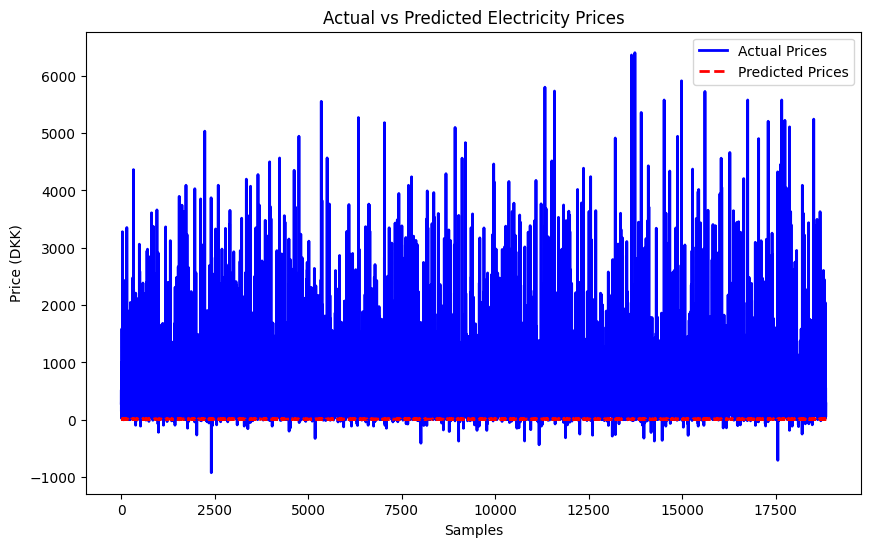

In [7]:
import matplotlib.pyplot as plt

# Step 1: Evaluate the model and make predictions
model.eval()
with torch.no_grad():
    predicted = model(X_test).numpy()  # Convert predictions to NumPy array
    actual = y_test.numpy()  # Convert actual values to NumPy array

# Step 2: Plot predictions vs actual prices
plt.figure(figsize=(10, 6))

# Plot actual prices
plt.plot(actual, label='Actual Prices', color='blue', linewidth=2)

# Plot predicted prices
plt.plot(predicted, label='Predicted Prices', color='red', linestyle='--', linewidth=2)

# Add title and labels
plt.title('Actual vs Predicted Electricity Prices')
plt.xlabel('Samples')
plt.ylabel('Price (DKK)')
plt.legend()

# Show the plot
plt.show()